In [21]:
import datetime
start_time = datetime.datetime.now()
start_time

datetime.datetime(2022, 4, 24, 19, 10, 2, 999421)

In [22]:
# Also runs installation of dependencies
from lib.util import *

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [24]:
df_discharge_2019 = pd.read_stata('../dataset/TEDS-D-2019-DS0001-bndl-data-stata_V1_0.zip', compression='zip')
df_discharge_2019

,DISYR,CASEID,STFIPS,CBSA2010,EDUC,MARSTAT,SERVICES,DETCRIM,LOS,PSOURCE,...,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
0,2019.0,2.019155e+10,2.0,-9.0,4.0,1.0,7.0,-9.0,37.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,1.0
1,2019.0,2.019147e+10,2.0,-9.0,3.0,1.0,7.0,-9.0,35.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,3.0
2,2019.0,2.019144e+10,2.0,-9.0,2.0,1.0,7.0,-9.0,35.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,3.0
3,2019.0,2.019141e+10,2.0,-9.0,3.0,1.0,7.0,-9.0,37.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,3.0
4,2019.0,2.019148e+10,2.0,-9.0,3.0,3.0,7.0,-9.0,37.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722498,2019.0,2.019174e+10,56.0,-9.0,4.0,2.0,7.0,-9.0,33.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,1.0
1722499,2019.0,2.019167e+10,56.0,-9.0,3.0,3.0,7.0,1.0,13.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,2.0
1722500,2019.0,2.019141e+10,56.0,-9.0,2.0,1.0,6.0,-9.0,33.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,2.0
1722501,2019.0,2.019170e+10,56.0,-9.0,1.0,1.0,7.0,3.0,14.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,3.0


In [25]:
state_cluster_0 = [ 1.0,  4.0,  5.0,  6.0,  8.0,  9.0, 10.0, 13.0, 15.0, 17.0, 18.0,
              19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0,
              31.0, 32.0, 34.0, 36.0, 39.0, 40.0, 44.0, 45.0, 46.0, 47.0, 48.0,
              49.0, 50.0, 55.0, 72.0]

In [26]:
def dataset_on_filter(df, filter_one:dict = None, filter_two:dict = None, filter_three:dict = None):
    df_processing = df.copy()

    if filter_one:
        for value in filter_one:
            df_processing = df_processing[df_processing[value] == filter_one[value]]

    if filter_two:
        for value in filter_two:
            df_processing = df_processing[df_processing[value] == filter_two[value]]

    if filter_three:
        for value in filter_three:
            df_processing = df_processing[df_processing[value] == filter_three[value]]

    df_filtered = df_processing.copy()
    name_str = '{}_{}_{}'.format(filter_one, filter_two, filter_three)
    df_filtered.name = name_str
    return df_filtered

In [27]:
def treatment_variable_transform(df, drop_value:list = None):
    df_processing = df.copy()

    # Drop certain record with REASON equals certain value(s)
    if drop_value:
        for value in drop_value:
            df_processing.drop(df_processing.index[df_processing['REASON'] == value], inplace=True)
    
    # Create the Treatment variable column with value 1 and 0 only
    df_processing['Treatment_Completed'] = (df_processing.REASON == 1)
    df_processing.replace(True, 1, inplace = True)
    df_processing.replace(False, 0,  inplace = True)

    df_transformed = df_processing
    return df_transformed

In [28]:
df_cluster_0 = df_discharge_2019.loc[df_discharge_2019['STFIPS'].isin(state_cluster_0)]

In [29]:
corrs = df_cluster_0[[ 'EDUC', 'MARSTAT', 'SERVICES',
       'DETCRIM', 'LOS', 'PSOURCE', 'NOPRIOR', 'ARRESTS', 'EMPLOY', 'METHUSE',
       'PSYPROB', 'LIVARAG', 'DAYWAIT',
       'DSMCRIT', 'AGE',
       'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'ROUTE1',
       'FREQ1', 'FRSTUSE1', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP',
       'IDU', 'ALCDRUG']]

In [30]:
target = treatment_variable_transform(df_cluster_0).Treatment_Completed

In [31]:
X_train, X_test, y_train, y_test = train_test_split(corrs, target, test_size=0.20, random_state=42)


In [32]:
y_test

1142290    0
61389      1
497345     1
1414301    0
515656     1
          ..
1028116    0
527587     1
940732     0
892049     0
1297188    0
Name: Treatment_Completed, Length: 276786, dtype: int64

In [33]:
# model = RandomForestClassifier(random_state=42)
# param_grid = { 
#     'n_estimators': [105, 110, 115],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [8,9,10],
#     'criterion' :['gini', 'entropy']
# }

# CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)

In [34]:
# CV_rfc.best_params_

In [35]:
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
print('Test Accuracy: {:.2f}'.format(model.score(X_test, y_test)))
print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

Test Accuracy: 0.82
Test AUC: 0.90


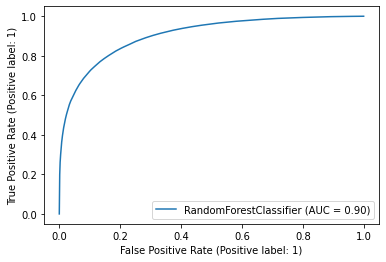

In [37]:
from sklearn import metrics
metrics.plot_roc_curve(model, X_test, y_test)
from matplotlib import pyplot
pyplot.savefig('../report/assets/roc.svg')

In [38]:
end_time = datetime.datetime.now()
end_time

datetime.datetime(2022, 4, 24, 19, 15, 42, 556971)

In [39]:
# How long it took to run our entire notebook
end_time - start_time

datetime.timedelta(seconds=339, microseconds=557550)